# 8-1. 프로젝트: 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약

라이브러리 버전 확인

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

- sunnysai12345/News_Summary : https://github.com/sunnysai12345/News_Summary

아래의 코드로 데이터를 다운로드할 수 있어요.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history."
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""In the #MeToo movement, I always believe a woman. But in this case, we need to reserve our judgment,"" she added. Hirani has been accused by an assistant who worked in 'Sanju'."


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

### Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [7]:
# 전체 데이터 갯수 확인
total_count = len(data)
print(f"Total number of rows: {total_count}")

Total number of rows: 98401


중복 샘플과 NULL 값이 존재하는 샘플 제거

In [8]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


text 자체가 중복이 된 경우는 중복 샘플이므로 제거

In [9]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


데이터프레임에 Null 값이 있는지 확인

In [10]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


headlines 와 text의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

text의 최소 길이 : 1
text의 최대 길이 : 91
text의 평균 길이 : 58.23813542090281
headlines_len의 최소 길이 : 1
headlines_len의 최대 길이 : 18
headlines_len의 평균 길이 : 9.553660024400163


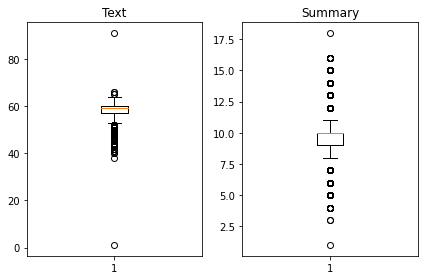

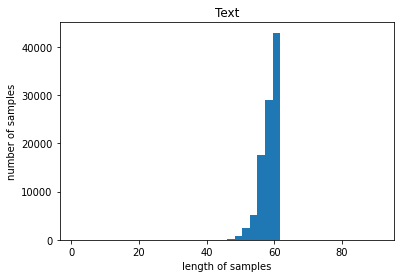

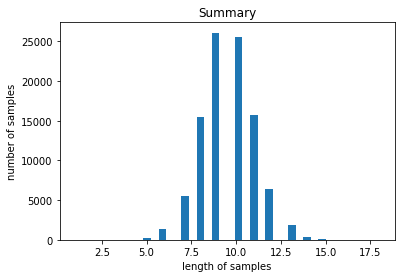

In [11]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text의 최소 길이 : {}'.format(np.min(text_len)))
print('text의 최대 길이 : {}'.format(np.max(text_len)))
print('text의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines_len의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines_len의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines_len의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

샘플의 최대 길이 정하기

최대 길이는 평균 + 2*표준편차

In [12]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

# 최대 길이 계산
text_mean = np.mean(text_len)
text_std = np.std(text_len)
headlines_mean = np.mean(headlines_len)
headlines_std = np.std(headlines_len)

max_text_len = int(text_mean + 2 * text_std)
max_headlines_len = int(headlines_mean + 2 * headlines_std)

print(f"text의 최대 길이 (평균 + 2*표준편차): {max_text_len}")
print(f"headlines의 최대 길이 (평균 + 2*표준편차): {max_headlines_len}")

text의 최대 길이 (평균 + 2*표준편차): 63
headlines의 최대 길이 (평균 + 2*표준편차): 12


훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수

In [13]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [14]:
below_threshold_len(max_text_len, data['text'])
below_threshold_len(max_headlines_len,  data['headlines'])

전체 샘플 중 길이가 63 이하인 샘플의 비율: 0.9997661651077674
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


In [15]:
# max_text_len 및 max_headlines_len보다 긴 샘플 제외
# data = data[(data['text'].apply(lambda x: len(x.split())) <= max_text_len) &
#             (data['headlines'].apply(lambda x: len(x.split())) <= max_headlines_len)]
data = data[(data['text'].apply(lambda x: len(x.split())) <= max_text_len) &
            (data['headlines'].apply(lambda x: len(x.split())) <= max_headlines_len)].reset_index(drop=True).copy()

print('최대 길이 조건을 만족하는 전체 샘플 수:', len(data))

최대 길이 조건을 만족하는 전체 샘플 수: 96059


- 데이터 shuffle

In [16]:
indices = np.arange(len(data))
np.random.shuffle(indices)
print(indices)

[55367 76898 41953 ... 95891 11526 78425]


In [17]:
data = data.iloc[indices]

- test 데이터 비율 0.2% 계산

In [18]:
n_of_val = int(len(data)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19211


Summa을 이용한 추출적 요약을 위해 별도의 변수에 copy

In [19]:
import copy

In [20]:
result_summarize_data = copy.deepcopy(data)

In [21]:
result_summarize_data_test = result_summarize_data[-n_of_val:]

In [22]:
len(result_summarize_data_test)

19211

In [23]:
result_summarize_data_test.head()

,headlines,text
64341,Delhi airport to get body scanner in 3rd trial run in years,"The Delhi airport will introduce a body scanner next month, as part of its third such trial run in years. Previous trials were unsuccessful as passengers had objected to X-ray images, and there were false alarms whenever women in sarees underwent the checks. Meanwhile, an official said, ""We have asked the manufacturer to tweak specifications as per the Indian standard."""
93275,"Iran offers to mediate between India, Pak over Kashmir issue","Iranian Ambassador to Pakistan Mehdi Honardoost has said that Iran is willing to mediate between Pakistan and India over the long-standing issue of Kashmir, if requested. Any conflict or tension between the two countries (Pakistan and India) will hinder the development of both the countries apart from impacting the economies of other regional countries, said Honardoost."
86259,Man faces Ã¢ÂÂ¹14 lakh fine for climbing Everest without permit,"A South African national is facing a ban on climbing for five years in Nepal and a fine of $22,000 (over Ã¢ÂÂ¹14 lakh) after attempting to scale Mount Everest without paying the permit fee, officials said on Wednesday. Forty-three-year-old Ryan Sean Davy's passport has also been confiscated, an official added. Notably, foreigners are charged $11,000 to climb Mount Everest."
35356,Pakistan lifts travel ban on Asia Bibi,"Pakistan has said that Asia Bibi, the Christian woman acquitted of blasphemy, has the right to travel anywhere inside the country or abroad. This came after Pakistan's Supreme Court upheld her acquittal, rejecting a petition by hardline Islamists. Pakistan had barred Bibi from travelling abroad following a deal with the Islamists who had opposed her acquittal and demanded her execution."
84041,I think Wonder Woman would kick Thor's a**: Chris Hemsworth,"Actor Chris Hemsworth, who portrays the character Thor in Marvel films, tweeted that Wonder Woman would kick Thor's a** if there was a battle between the two. Earlier, Gal Gadot, who portrays Wonder Woman had said in an interview, ""They ask me, who would win? Wonder Woman or Thor? And I think it's Wonder Woman. Don't you, Chris?""n"


### 시작 토큰과 종료 토큰 추가하기

- seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요 있음
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input
- 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target
- 두 개의 문장 모두 headlines 열로부터 만듬

In [25]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
55367,Google Doodle honours India's 1st woman photojournalist,"Google Doodle on Saturday celebrated the 104th birth anniversary of India's first woman photojournalist Homai Vyarawalla. A Padma Bhushan awardee, Vyarawalla was born in Gujarat and picked up photography from her husband. Her pictures include the first tricolour-hoisting after the Independence, Lord Mountbatten departing from India and Jawaharlal Nehru addressing the crowd after the Independence.",sostoken Google Doodle honours India's 1st woman photojournalist,Google Doodle honours India's 1st woman photojournalist eostoken
76898,I stress on female comedians not being eye-candy: Sugandha,"Comedian Sugandha Mishra said she stresses on female comedians not being made eye-candy. She added that sometimes, makers of a comedy show keep women only for cues and give main lines to men. Sugandha further said that initially, good-looking girls find it difficult doing comedy as they're confused about negative portrayals, as is sometimes required in comedy shows.",sostoken I stress on female comedians not being eye-candy: Sugandha,I stress on female comedians not being eye-candy: Sugandha eostoken
41953,Indonesian province mulls beheading as penalty for murder,"Indonesian province of Aceh is considering to introduce beheading as a punishment for murder, the head of the province's sharia law and human rights office has said. ""Beheading is more in line with Islamic law and will cause a deterrent effect,"" the official added. Aceh, which practices public caning against homosexuality, is the only Indonesian province which follows sharia law.",sostoken Indonesian province mulls beheading as penalty for murder,Indonesian province mulls beheading as penalty for murder eostoken
2206,MS Dhoni spends time with 87-year-old fan after practice in Sydney,"Former India captain MS Dhoni met his 87-year-old Australian fan Edith Kochanek after a practice session at Sydney Cricket Ground (SCG). Edith had come to the stadium with her son Norman to watch Dhoni train. ""I was very lucky to meet MS Dhoni. I feel very privileged and proud,"" said Edith, who had also watched Don Bradman train at SCG.",sostoken MS Dhoni spends time with 87-year-old fan after practice in Sydney,MS Dhoni spends time with 87-year-old fan after practice in Sydney eostoken
92837,US visa the only issue for IT industry: Infosys Co-founder,"Infosys Co-founder Kris Gopalakrishnan has said the Indian IT industry will see steady growth and that the US H-1B visa will be the only major issue this year. ""That's one challenge I see. I don't see anything particularly different this year,"" he stated. If global GDP grows around 2-3%, Indian IT industry will grow by around 10%, he added.",sostoken US visa the only issue for IT industry: Infosys Co-founder,US visa the only issue for IT industry: Infosys Co-founder eostoken


텍스트 정규화와 불용어 제거

- 정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

- Text: text의 평균 길이가 58이므로 불용어 제거는 더 간결하고 핵심적인 정보로 만들 수 있음
- Headlines: headlines의 평균 길이가 9.5로 짧기 때문에, 불용어 제거 시 중요한 정보까지 제거될 위험. 요약 데이터는 본래 핵심 정보를 담고 있기 때문에, 불용어를 제거하는 대신 원문 그대로 사용

--> 리뷰 완료 후 불용어 제거 안 하는 모델로 다시 실험함
"언어의 맥락을 이해해야 하는 NLP 모델(예: BERT, GPT)에서는 불용어가 오히려 중요한 의미를 가질 수 있습니다. 예를 들어, "not good"에서 "not"을 제거하면 원래 문장의 의미가 변질될 수 있습니다."


In [26]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거

In [27]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- 불용어를 제거
- 영어 문자는 소문자
- 섞여있는 html 태그를 제거
- 정규 표현식을 통해 각종 특수문자를 제거

In [28]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

preprocess_sentence() test

In [29]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [30]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

for sentence in data['text']:
    # clean_text.append(preprocess_sentence(sentence))
    clean_text.append(preprocess_sentence(sentence, remove_stopwords=False)) # 불용어 제거 안함

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['google doodle on saturday celebrated the th birth anniversary of india first woman photojournalist homai vyarawalla padma bhushan awardee vyarawalla was born in gujarat and picked up photography from her husband her pictures include the first tricolour hoisting after the independence lord mountbatten departing from india and jawaharlal nehru addressing the crowd after the independence', 'comedian sugandha mishra said she stresses on female comedians not being made eye candy she added that sometimes makers of comedy show keep women only for cues and give main lines to men sugandha further said that initially good looking girls find it difficult doing comedy as they are confused about negative portrayals as is sometimes required in comedy shows', 'indonesian province of aceh is considering to introduce beheading as punishment for murder the head of the province sharia law and human rights office has said beheading is more in line with islamic law and will cause deterren

In [31]:
# 전체 Summary 데이터에 대한 전처리: 시간이 오래 걸릴 수 있음
clean_headlines = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['google doodle honours india st woman photojournalist', 'stress on female comedians not being eye candy sugandha', 'indonesian province mulls beheading as penalty for murder', 'ms dhoni spends time with year old fan after practice in sydney', 'us visa the only issue for it industry infosys co founder']


- empty 샘플이 생겼는지 확인
- empty 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체

In [32]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [33]:
# Null 값 확인
data.isnull().sum()

headlines         0
text              0
decoder_input     0
decoder_target    0
dtype: int64

In [34]:
# # Null 값 제거
# data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96059


### 훈련 데이터와 테스트 데이터를 분리

In [35]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

In [37]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_target_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_target_test))

훈련 데이터의 개수 : 76848
훈련 레이블의 개수 : 76848
테스트 데이터의 개수 : 19211
테스트 레이블의 개수 : 19211


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

In [38]:
src_tokenizer = Tokenizer(oov_token='UNK') # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인  
src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보 확인

In [39]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69306
등장 빈도가 6번 이하인 희귀 단어의 수: 47100
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22206
단어 집합에서 희귀 단어의 비율: 67.95948402735694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.204872969142618


- 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 68% 이상을 차지
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 2.21%
- 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
- 단어의 등장 빈도 수를 예제와 같이 7회 미만으로 잡았는데 기준이 모호하지만 통계 결과에서는 큰 문제가 없어 보인다.
- 이를 제외한 단어 집합의 크기를 2만여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 22,000으로 제한
- 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있음

In [40]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab, oov_token='UNK')
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 재생성

- texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
- 현재 단어 집합의 크기를 22,000으로 제한했으니까 이제 22,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음

In [41]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[277, 9664, 7, 157, 2167, 2, 197, 966, 1202, 5, 30, 49, 128, 13853, 1, 1, 2938, 3232, 6511, 1, 12, 922, 4, 460, 6, 1907, 66, 10730, 19, 35, 526, 35, 680, 784, 2, 49, 6283, 12600, 20, 2, 1256, 1330, 1, 15967, 19, 30, 6, 3510, 2671, 875, 2, 2260, 20, 2, 1256], [2083, 14794, 2213, 10, 43, 1, 7, 584, 12601, 26, 77, 118, 2293, 8856, 43, 34, 11, 2591, 2335, 5, 2440, 247, 835, 115, 116, 9, 14795, 6, 456, 1465, 2510, 3, 288, 14794, 64, 10, 11, 2011, 421, 905, 778, 917, 18, 1870, 689, 2440, 21, 52, 40, 6678, 51, 2635, 1, 21, 13, 2591, 1175, 4, 2440, 523], [4074, 2183, 5, 16674, 13, 2194, 3, 2757, 11292, 21, 2997, 9, 710, 2, 473, 5, 2, 2183, 11577, 320, 6, 402, 612, 472, 8, 10, 11292, 13, 120, 4, 879, 16, 1093, 320, 6, 22, 1090, 17474, 1722, 2, 238, 34, 16674, 33, 3394, 249, 1, 46, 5097, 13, 2, 116, 4074, 2183, 33, 2890, 11577, 320]]


- headlines 데이터에 대해서도 동일한 작업을 수행
- 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산
- 단어의 등장 빈도 수를 6회 미만으로 잡았는데 기준이 모호하지만 통계 결과에서는 큰 문제가 없어 보인다.

In [42]:
tar_tokenizer = Tokenizer(oov_token='UNK')
tar_tokenizer.fit_on_texts(decoder_input_train)

In [43]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40501
등장 빈도가 5번 이하인 희귀 단어의 수: 29298
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11203
단어 집합에서 희귀 단어의 비율: 72.33895459371374
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.287927930112579


In [44]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab, oov_token='UNK')
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[2, 110, 5868, 3325, 89, 48, 47, 1], [2, 26, 4028, 8, 464, 1, 21, 111, 2277, 5176, 1], [2, 2489, 6124, 2278, 7178, 17, 1197, 6, 358], [2, 1086, 295, 2922, 60, 9, 3906, 40, 28, 529, 10, 2350, 5, 8056], [2, 16, 1124, 19, 138, 552, 6, 62, 1224, 720, 326, 291]]
target
decoder  [[110, 5868, 3325, 89, 48, 47, 1, 3], [26, 4028, 8, 464, 1, 21, 111, 2277, 5176, 1, 3], [2489, 6124, 2278, 7178, 17, 1197, 6, 358, 3], [1086, 295, 2922, 60, 9, 3906, 40, 28, 529, 10, 2350, 5, 8056, 3], [16, 1124, 19, 138, 552, 6, 62, 1224, 720, 326, 291, 3]]


- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성 있음

- 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장. 이 샘플들이 있으면 모두 삭제

In [45]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [46]:
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76848
훈련 레이블의 개수 : 76848
테스트 데이터의 개수 : 19211
테스트 레이블의 개수 : 19211


### padding 방식 'post' 사용
- 어제 test 시 post, pre 가 별 차이 없이 나왔다.
- 특히 오늘은 attention 테크닉을 사용하는 모델이기 때문에 post 와 pre 가 큰 차이점이 없을 거라고 예상하고 post 를 먼저 사용해서 전처리 하도록 한다.

In [47]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_text_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_text_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_headlines_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=max_headlines_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_headlines_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_headlines_len, padding='post')

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 함수형 API를 이용해서 인코더를 설계

In [48]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

- 인코더 부분을 3개의 LSTM 레이어로 구성
- recurrent_dropout 는 학습 시간 고려하여 사용하지 않음

In [49]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(max_text_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

### 디코더 설계

In [50]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

### 어텐션 메커니즘

In [51]:
from tensorflow.keras.layers import AdditiveAttention

In [52]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

- Additive Attention 층을 사용: 이 층은 Additive Attention(어텐션) 메커니즘을 사용하여 디코더의 출력과 인코더의 출력을 결합
- Additive Attention은 Bahdanau 어텐션으로도 불리며, 주어진 인코더와 디코더의 hidden state를 바탕으로 중요도를 계산

In [53]:
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

- 어텐션 결과 계산: 인코더의 출력 (encoder_outputs)과 디코더의 출력 (decoder_outputs)을 어텐션 층에 전달하여, 어텐션 가중치를 기반으로 두 출력을 결합한 결과를 얻음
- attn_out은 인코더의 모든 time step에 걸친 정보가 디코더의 각 time step에 대한 중요도로 조정되어 계산된 결과

In [54]:
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

- 어텐션 결과와 디코더 출력 결합: 어텐션의 결과 (attn_out)와 디코더의 각 time step의 hidden state (decoder_outputs)를 결합
- 이를 통해 디코더는 인코더에서 가장 중요한 정보와 자신의 hidden state를 결합하여 최종 출력을 생성
- Concatenate는 두 텐서를 축(axis)을 기준으로 합침. 여기서는 마지막 축(axis=-1)으로 합침

In [55]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

- Dense 층을 사용한 출력층: tar_vocab 크기를 갖는 밀집(Dense) 층을 통해 각 단어에 대한 확률 분포를 구함.
- Softmax 활성화 함수를 사용하여 각 단어가 정답일 확률을 계산
- decoder_concat_input을 입력받아, 각 time step에서 출력될 단어에 대한 확률을 산출

In [56]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 63)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 63, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 63, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 모델 훈련하기

- EarlyStopping 사용안함
- ModelCheckpoint 로 가장 좋은 모델 저장

In [57]:
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
#           validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
#           batch_size=256, callbacks=[es], epochs=50)

In [58]:
import tensorflow as tf

In [59]:
# 콜백 설정 - 가장 좋은 모델을 저장하도록 설정
seq2seq_attention_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('seq2seq_attention_model.keras', save_best_only=True)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

epochs = 50 # 40

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, callbacks=[seq2seq_attention_checkpoint_cb], epochs=epochs)

Epoch 1/50
301/301 [==============================] - 70s 115ms/step - loss: 5.9651 - val_loss: 5.5579
Epoch 2/50
301/301 [==============================] - 34s 114ms/step - loss: 5.4015 - val_loss: 5.1927
Epoch 3/50
301/301 [==============================] - 35s 116ms/step - loss: 5.0210 - val_loss: 4.8920
Epoch 4/50
301/301 [==============================] - 36s 119ms/step - loss: 4.7280 - val_loss: 4.6421
Epoch 5/50
301/301 [==============================] - 36s 120ms/step - loss: 4.4994 - val_loss: 4.4742
Epoch 6/50
301/301 [==============================] - 36s 119ms/step - loss: 4.3118 - val_loss: 4.3625
Epoch 7/50
301/301 [==============================] - 36s 120ms/step - loss: 4.1529 - val_loss: 4.2666
Epoch 8/50
301/301 [==============================] - 36s 119ms/step - loss: 4.0172 - val_loss: 4.1803
Epoch 9/50
301/301 [==============================] - 36s 119ms/step - loss: 3.8974 - val_loss: 4.1138
Epoch 10/50
301/301 [==============================] - 36s 119ms/step - l

### loss, val_loss 시각화

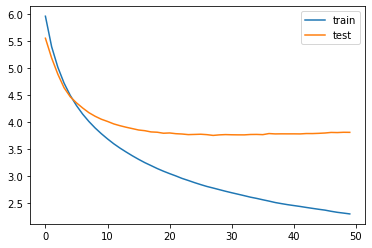

In [60]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [61]:
# 저장된 가장 좋은 모델 로드
seq2seq_attention_best_model = tf.keras.models.load_model('seq2seq_attention_model.keras')

### 인퍼런스 모델 구현

- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 함
- 필요한 3개의 사전을 아래와 같이 미리 준비

In [62]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 별도의 모델 설계 필요함
- 이때는 인코더 모델과 디코더 모델을 분리해서 설계

In [63]:
# 인코더 설계
# encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [64]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(max_text_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [65]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기

In [66]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

In [67]:
# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i == 0):  # 패딩 토큰은 무시합니다.
            continue
        if (i == tar_word_to_index['sostoken']):  # 시작 토큰은 무시합니다.
            continue
        if (i == tar_word_to_index['eostoken']):  # 종료 토큰에서 변환을 멈춥니다.
            break
        temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()  # 마지막 공백 제거

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

### 정량적 평가를 위한 BLEU 점수 계산 (nltk 사용)

In [116]:
#!pip install bert-score

In [113]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score

In [115]:
smoothie = SmoothingFunction().method4

bleu_scores = []
bertscore_precisions = []
bertscore_recalls = []
bertscore_fscores = []

for i in range(0, 50):
    reference = seq2summary(decoder_input_test[i]).split()
    candidate = decode_sequence(encoder_input_test[i].reshape(1, max_text_len)).split()
    
    # BLEU Score Calculation
    bleu_score = sentence_bleu([reference], candidate, smoothing_function=smoothie)
    bleu_scores.append(bleu_score)
    
    # BERTScore Calculation
    reference_str = ' '.join(reference)
    candidate_str = ' '.join(candidate)
    P, R, F1 = score([candidate_str], [reference_str], lang="en", rescale_with_baseline=True)
    bertscore_precisions.append(P.mean().item())
    bertscore_recalls.append(R.mean().item())
    bertscore_fscores.append(F1.mean().item())
    
    # Print results
    # print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 headlines :", reference_str)
    print("예측 요약 :", candidate_str)
    print("BLEU Score :", bleu_score)
    print(f"BERTScore - Precision: {P.mean().item():.4f}, Recall: {R.mean().item():.4f}, F1: {F1.mean().item():.4f}")
    print("\n")

# Print average scores
print("Average BLEU Score :", np.mean(bleu_scores))
print("Average BERTScore - Precision :", np.mean(bertscore_precisions))
print("Average BERTScore - Recall :", np.mean(bertscore_recalls))
print("Average BERTScore - F1 :", np.mean(bertscore_fscores))

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : delhi airport to get body scanner in 3rd trial run in years
예측 요약 : delhi airport to get UNK UNK treatment
BLEU Score : 0.20126703311713304
BERTScore - Precision: 0.3119, Recall: 0.2941, F1: 0.3041




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : iran offers to mediate between india pak over kashmir issue
예측 요약 : iran UNK UNK UNK to pak it iran
BLEU Score : 0.029313448501677924
BERTScore - Precision: -0.1779, Recall: -0.1481, F1: -0.1612




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : man faces ã¢ââ¹14 lakh fine for climbing everest without permit
예측 요약 : south african south africa banned for over UNK
BLEU Score : 0.0222734042410851
BERTScore - Precision: -0.1231, Recall: -0.4550, F1: -0.2929




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : pakistan lifts travel ban on asia UNK
예측 요약 : pakistan is christian woman in law pakistan
BLEU Score : 0.03235934848975789
BERTScore - Precision: 0.1371, Recall: 0.0125, F1: 0.0755




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : i think wonder woman would kick UNK a chris UNK
예측 요약 : chris chris chris chris chris gayle chris chris chopra
BLEU Score : 0.02302676613984314
BERTScore - Precision: -0.0249, Recall: -0.1762, F1: -0.0999




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : don't want to blow your mind but i'm pretty UNK musk
예측 요약 : we don't want to make you feel like UNK elon musk
BLEU Score : 0.13190955568171472
BERTScore - Precision: 0.3386, Recall: 0.3501, F1: 0.3454




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : menu of first indian restaurant in uk auctioned for ã¢ââ¹7 UNK
예측 요약 : UNK UNK UNK UNK opens in uk for first time
BLEU Score : 0.06479712906415719
BERTScore - Precision: 0.0262, Recall: -0.2876, F1: -0.1340




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : brexit french poll changed my view of europe angela merkel
예측 요약 : german chancellor merkel could be german chancellor merkel
BLEU Score : 0.0222734042410851
BERTScore - Precision: 0.0839, Recall: -0.0082, F1: 0.0390




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : reliance calls reports of listing jio UNK rumours
예측 요약 : jio UNK merger is reports of UNK UNK
BLEU Score : 0.10073051057692405
BERTScore - Precision: 0.2485, Recall: 0.2089, F1: 0.2298




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : saturn may have helped create jupiter's large UNK study
예측 요약 : UNK to be UNK on earth as its own planet study
BLEU Score : 0.02568481047180467
BERTScore - Precision: 0.1247, Recall: 0.0626, F1: 0.0949




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : dalit youth should join the army for UNK minister UNK
예측 요약 : union minister seeks to make UNK UNK mandatory
BLEU Score : 0.029313448501677924
BERTScore - Precision: 0.2483, Recall: 0.0055, F1: 0.1254




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : man on vacation mistaken for h'wood actor morgan UNK
예측 요약 : man gets UNK UNK into house after he gets UNK
BLEU Score : 0.027895820162122397
BERTScore - Precision: 0.0565, Recall: -0.1432, F1: -0.0437




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : bolt wins UNK UNK in his career's UNK race
예측 요약 : bolt scores UNK UNK UNK in world c'ships
BLEU Score : 0.16552841185194125
BERTScore - Precision: 0.2433, Recall: 0.2830, F1: 0.2643




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : nasa astronaut UNK to walk on earth after UNK days in space
예측 요약 : nasa shares fall after moon UNK UNK UNK
BLEU Score : 0.024531718725020534
BERTScore - Precision: 0.1211, Recall: 0.0152, F1: 0.0691




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : paes most successful doubles player in UNK cup of UNK
예측 요약 : UNK wins world no 1 in world cup final world cup
BLEU Score : 0.028424915360075714
BERTScore - Precision: 0.1392, Recall: 0.1226, F1: 0.1323




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : whatsapp allows UNK to operate outside law uk
예측 요약 : UNK UNK to stop social media UNK
BLEU Score : 0.07103125716740531
BERTScore - Precision: 0.1699, Recall: 0.1348, F1: 0.1537




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : 2 killed over fake whatsapp messages on child trafficking
예측 요약 : 2 men killed in tamil nadu via whatsapp collision
BLEU Score : 0.033866335496821456
BERTScore - Precision: 0.0453, Recall: 0.2718, F1: 0.1574




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : songs today just like one day cricket match UNK UNK
예측 요약 : i played more UNK in the songs in all time rahman
BLEU Score : 0.02568481047180467
BERTScore - Precision: 0.0158, Recall: -0.0704, F1: -0.0260




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : liquor firm UNK cuts ceo's pay by over ã¢ââ¹9 crore
예측 요약 : UNK ordered to pay UNK UNK for UNK UNK
BLEU Score : 0.027383594129005207
BERTScore - Precision: 0.1557, Recall: -0.3975, F1: -0.1350




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : coffee machine forces flight to make emergency landing
예측 요약 : flight makes emergency landing after flight gets UNK
BLEU Score : 0.07882588442342651
BERTScore - Precision: 0.3742, Recall: 0.5320, F1: 0.4528




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : scientists claim to find earliest evidence of life on earth
예측 요약 : life life of life UNK UNK UNK
BLEU Score : 0.05337837685989625
BERTScore - Precision: -0.2810, Recall: -0.1930, F1: -0.2354




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : school UNK car runs over students in telangana
예측 요약 : school student killed as car runs in car in car accident
BLEU Score : 0.061729293904138435
BERTScore - Precision: 0.3463, Recall: -0.0092, F1: 0.1637




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : isis UNK death toll in us UNK jumps to 90
예측 요약 : isis UNK kills 9 11 attacks in afghanistan
BLEU Score : 0.061389660515260625
BERTScore - Precision: 0.1519, Recall: 0.2504, F1: 0.2020




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : swiggy zomato to raise funds from same investor report
예측 요약 : swiggy to raise 50 million to UNK report
BLEU Score : 0.07475095167059852
BERTScore - Precision: 0.2558, Recall: 0.2365, F1: 0.2473




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : mumbai civic body to start door to door garbage collection
예측 요약 : mumbai civic body to waste waste collection of waste
BLEU Score : 0.2824099048856541
BERTScore - Precision: 0.6448, Recall: 0.5421, F1: 0.5937




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : fssai had UNK unauthorised UNK employees cag
예측 요약 : mcdonald's told to be UNK UNK employees
BLEU Score : 0.09068059995923879
BERTScore - Precision: 0.1265, Recall: -0.0902, F1: 0.0174




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : world's biggest x ray laser UNK first laser light
예측 요약 : world's largest UNK UNK UNK made for the world's first time
BLEU Score : 0.028424915360075714
BERTScore - Precision: 0.2317, Recall: 0.1795, F1: 0.2068




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : cong issues show cause notice to ex k'taka assembly speaker
예측 요약 : cong leader files complaint against cong leaders over remarks
BLEU Score : 0.02302676613984314
BERTScore - Precision: 0.2278, Recall: 0.0716, F1: 0.1498




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : apple app store developers earned 120 billion since 2008
예측 요약 : apple store store earned more store in the store report
BLEU Score : 0.03087179980863256
BERTScore - Precision: 0.1432, Recall: 0.0821, F1: 0.1139




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : yashwant sinha shatrughan back aap on mla disqualification
예측 요약 : aap leader calls aap UNK UNK UNK UNK
BLEU Score : 0.028599617161713803
BERTScore - Precision: -0.2235, Recall: -0.3978, F1: -0.3102




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : UNK scores maiden test ton england lead by 250 runs
예측 요약 : england end UNK UNK after UNK runs
BLEU Score : 0.027743029026610813
BERTScore - Precision: -0.0939, Recall: -0.1579, F1: -0.1243




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : pic shows UNK 000 troops to UNK in notes of us official
예측 요약 : us UNK UNK UNK UNK with UNK UNK
BLEU Score : 0.022829336647630066
BERTScore - Precision: 0.0277, Recall: -0.0725, F1: -0.0213




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : india end day 2 at 120 1 trail australia by UNK runs
예측 요약 : UNK UNK dropped from india after being out of india
BLEU Score : 0.022839165849062423
BERTScore - Precision: 0.1473, Recall: -0.0085, F1: 0.0697




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : won't have more than 2 kids says geeta phogat
예측 요약 : phogat denies UNK of UNK girls' marriage
BLEU Score : 0.024317315608763098
BERTScore - Precision: -0.0272, Recall: 0.0057, F1: -0.0092




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : sidhu announces UNK compensation to farmers from his pocket
예측 요약 : sidhu khan to pay ã¢ââ¹1 lakh for UNK UNK
BLEU Score : 0.033866335496821456
BERTScore - Precision: -0.3906, Recall: 0.1769, F1: -0.1217




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : jk rowling named europe's highest paid celebrity of 2017
예측 요약 : harry potter UNK highest ever UNK of 2017 2017
BLEU Score : 0.0699543285114998
BERTScore - Precision: 0.0230, Recall: 0.0091, F1: 0.0176




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : eden gardens named best venue and ground of ipl 2018
예측 요약 : ganguly is the best UNK ganguly
BLEU Score : 0.019301097505701307
BERTScore - Precision: -0.1396, Recall: -0.1421, F1: -0.1390




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : floating nuclear plant launched slammed as nuclear titanic
예측 요약 : russia launches nuclear UNK for nuclear alert
BLEU Score : 0.033359167130736105
BERTScore - Precision: -0.0234, Recall: 0.1681, F1: 0.0720




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : sc stays j k hc order on lifetime security to ex judges
예측 요약 : sc asks j k to UNK UNK to UNK UNK
BLEU Score : 0.055449650454634784
BERTScore - Precision: -0.0972, Recall: 0.0120, F1: -0.0415




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : why was google fined UNK crore by indian watchdog
예측 요약 : google india google UNK UNK UNK on google
BLEU Score : 0.03001448585400683
BERTScore - Precision: -0.0216, Recall: -0.0103, F1: -0.0143




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : my daughter jhanvi is a fan of deepika padukone juhi chawla
예측 요약 : my daughter UNK me as much as my husband UNK
BLEU Score : 0.05153126005286493
BERTScore - Precision: 0.0660, Recall: -0.2817, F1: -0.1123




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : hindu community is in anger vhp on alwar cow UNK case
예측 요약 : cow UNK UNK in bulandshahr not hindu cow vigilantes
BLEU Score : 0.06019208559595749
BERTScore - Precision: -0.1305, Recall: 0.0362, F1: -0.0468




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : 3 5 lakh gujarat college students to get UNK tablets at UNK
예측 요약 : iit UNK to introduce UNK for UNK
BLEU Score : 0.02084825635462658
BERTScore - Precision: 0.2675, Recall: 0.0428, F1: 0.1540




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : google earth adds 33 sites where game of thrones was shot
예측 요약 : google UNK UNK UNK UNK UNK
BLEU Score : 0.016338026308907974
BERTScore - Precision: -0.3736, Recall: -0.2518, F1: -0.3114




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : what is truth behind pic showing rathore serving food to athletes
예측 요약 : sports minister gifts india kg to finish winners athletes
BLEU Score : 0.024503916662321008
BERTScore - Precision: 0.0717, Recall: -0.0098, F1: 0.0322




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : us defeat belgium to win UNK world cup for third time
예측 요약 : world cup winning world cup trophy UNK UNK
BLEU Score : 0.05417618525543734
BERTScore - Precision: 0.1980, Recall: -0.0032, F1: 0.0969




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : congress single largest party in mp after 24 hours of counting
예측 요약 : congress mp UNK UNK UNK UNK
BLEU Score : 0.019429297131655008
BERTScore - Precision: -0.3625, Recall: -0.1034, F1: -0.2345




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : aliens might have lived twice on the moon claims study
예측 요약 : UNK UNK may have impact of earth study
BLEU Score : 0.026487690798830184
BERTScore - Precision: 0.0341, Recall: 0.1393, F1: 0.0876




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : russia unveils president putin's new UNK to public
예측 요약 : putin releases new holiday UNK with UNK UNK UNK
BLEU Score : 0.030601688609851067
BERTScore - Precision: -0.0123, Recall: 0.0474, F1: 0.0190




Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


실제 headlines : students at iit madras protest sanskrit song at event
예측 요약 : du students protest in tamil song from singing UNK
BLEU Score : 0.033866335496821456
BERTScore - Precision: 0.2816, Recall: 0.1469, F1: 0.2147


Average BLEU Score : 0.05158064294864552
Average BERTScore - Precision : 0.07164786485955119
Average BERTScore - Recall : 0.02043575150426477
Average BERTScore - F1 : 0.04575144739821553


#### Average BLEU Score / BERTScore 추가

- Average BLEU Score : 0.05158064294864552
- Average BERTScore - Precision : 0.07164786485955119
- Average BERTScore - Recall : 0.02043575150426477
- Average BERTScore - F1 : 0.04575144739821553
- 점수가 낮다

### Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

### summarize 사용하기
---
Summa의 summarize()의 인자

> text (str) : 요약할 테스트.  
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
words (int or None, optional) – 출력에 포함할 단어 수.  
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.  
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환  

- Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
- 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있음
- 원문의 0.005%만을 출력하도록 설정

In [73]:
import requests
from summa.summarizer import summarize

In [121]:
predicted_summaries = []
extractive_summaries = []

for idx in range(0, 50):
    text = result_summarize_data_test['text'].iloc[idx]
    head = result_summarize_data_test['headlines'].iloc[idx]
    candidate = decode_sequence(encoder_input_test[idx].reshape(1, max_text_len)).split()
    predicted_summaries.append(candidate)  # 예측 요약을 리스트로 저장
    extractive_summary = summarize(text, ratio=0.4)
    extractive_summaries.append(extractive_summary)
    print("원문 :", text)
    print("Headlines :", head)
    print("추상적 요약 :", ' '.join(candidate))
    print("추출적 요약 :", extractive_summary)
    print("\n")
    

원문 : The Delhi airport will introduce a body scanner next month, as part of its third such trial run in years. Previous trials were unsuccessful as passengers had objected to X-ray images, and there were false alarms whenever women in sarees underwent the checks. Meanwhile, an official said, "We have asked the manufacturer to tweak specifications as per the Indian standard." 
Headlines : Delhi airport to get body scanner in 3rd trial run in years
추상적 요약 : delhi airport to get UNK UNK treatment
추출적 요약 : The Delhi airport will introduce a body scanner next month, as part of its third such trial run in years.


원문 : Iranian Ambassador to Pakistan Mehdi Honardoost has said that Iran is willing to mediate between Pakistan and India over the long-standing issue of Kashmir, if requested. Any conflict or tension between the two countries (Pakistan and India) will hinder the development of both the countries apart from impacting the economies of other regional countries, said Honardoost.
Headli

원문 : Indian tennis player Leander Paes set the record for the most number of doubles wins in Davis Cup, also known as the 'World Cup of Tennis', registering his 43rd win in the doubles rubber of the Asia/Oceania Group I tie. Paes teamed with Rohan Bopanna to beat China's doubles pair. India won 3-2 to advance to the World Group Play-offs.
Headlines : Paes most successful doubles player in 'World Cup of Tennis'
추상적 요약 : UNK wins world no 1 in world cup final world cup
추출적 요약 : Indian tennis player Leander Paes set the record for the most number of doubles wins in Davis Cup, also known as the 'World Cup of Tennis', registering his 43rd win in the doubles rubber of the Asia/Oceania Group I tie.


원문 : British Interior Minister Amber Rudd on Tuesday said that WhatsApp's end-to-end encryption communication services allowed paedophiles and other criminals to operate beyond the reach of the law. Adding that she wants the "flawed" technology to be changed, Rudd called on technology giants incl

원문 : Karnataka Congress President Dinesh Gundu Rao has issued a show cause notice to former Assembly speaker KB Koliwad after he claimed certain Congress MLAs were the reason CM HD Kumaraswamy broke down in tears. The notice stated, "This statement has caused immense embarrassment to the Congress...Expressing discontentment publicly through media is against the principles of the party." 
Headlines : Cong issues show cause notice to ex-K'taka Assembly Speaker
추상적 요약 : cong leader files complaint against cong leaders over remarks
추출적 요약 : 


원문 : Apple revealed its App Store developers have earned $120 billion since the launch of the App Store in 2008. It added developers earned over a quarter of the total earnings in the last year alone. "App Store is the new digital main street, and creative developers are tapping into the vast potential of...global app economy," an Apple senior director said.
Headlines :  Apple App Store developers earned $120 billion since 2008 
추상적 요약 : apple store 

원문 : Around 3.5 lakh first year college students in Gujarat will receive 7-inch 'NAMO E-Tab' tablets at a subsidised rate under a state government scheme launched on Saturday. The tablets, which retail at a price of Ã¢ÂÂ¹8,000 each, will be available to students for Ã¢ÂÂ¹1,000 each. NAMO E-Tab is the acronym for 'New Avenues of Modern Education through Tablets.'
Headlines : 3.5 lakh Gujarat college students to get NAMO tablets at Ã¢ÂÂ¹1k
추상적 요약 : iit UNK to introduce UNK for UNK
추출적 요약 : Around 3.5 lakh first year college students in Gujarat will receive 7-inch 'NAMO E-Tab' tablets at a subsidised rate under a state government scheme launched on Saturday.


원문 : Google Earth has added 33 locations where key scenes of 'Game of Thrones' were filmed. The locations include a bullring in southern Spain which depicted the Arena of Meereen and Croatia's St Dominic Street where Cersei Lannister's walk of shame was shot. Doune Castle in Scotland, a part of which is shown as Winterfell, is al

### 추출적 요약과 추상적 요약을 비교하는 Table 생성

In [122]:
comparison_data = {
    '추상적 요약': [' '.join(summary) for summary in predicted_summaries],
    '추출적 요약': extractive_summaries
}

In [123]:
comparison_df = pd.DataFrame(comparison_data)

In [124]:
comparison_df

,추상적 요약,추출적 요약
0,delhi airport to get UNK UNK treatment,"The Delhi airport will introduce a body scanner next month, as part of its third such trial run in years."
1,iran UNK UNK UNK to pak it iran,
2,south african south africa banned for over UNK,"A South African national is facing a ban on climbing for five years in Nepal and a fine of $22,000 (over Ã¢ÂÂ¹14 lakh) after attempting to scale Mount Everest without paying the permit fee, officials said on Wednesday."
3,pakistan is christian woman in law pakistan,Pakistan had barred Bibi from travelling abroad following a deal with the Islamists who had opposed her acquittal and demanded her execution.
4,chris chris chris chris chris gayle chris chris chopra,"Actor Chris Hemsworth, who portrays the character Thor in Marvel films, tweeted that Wonder Woman would kick Thor's a** if there was a battle between the two.\nWonder Woman or Thor?"
5,we don't want to make you feel like UNK elon musk,"It's time the world knew."" Earlier, Musk admitted he is dating Grimes after the two appeared at the Met Gala together."
6,UNK UNK UNK UNK opens in uk for first time,The handwritten menu of the first Indian restaurant opened in the UK has been auctioned for nearly Ã¢ÂÂ¹7.6 lakh.
7,german chancellor merkel could be german chancellor merkel,
8,jio UNK merger is reports of UNK UNK,"""We do not comment on media speculation and rumours,"" a Reliance spokesperson said."
9,UNK to be UNK on earth as its own planet study,


- seq2text(encoder_input_test[idx]) 를 이용하면 Extractive 요약이 생성이 되지 않아 indices 을 이용해서 result_summarize_data 를 인덱싱 하였음
- 하지만 Extractive 요약과 Abstractive 요약의 index 가 맞지 않는다;;;
    -> 디버깅 후 수정 완료

### 회고

- 자연어 모델에 데이터를 넣기 까지 해야 할 일이 너무 많다
- 튜토리얼 없이 처음 부터 끝까지 할 수 있을까?? 라는 의문이 생겼다.
- 단어의 등장 빈도 수를 예제와 같이 7회 미만과 6회 미만으로 잡았는데 기준이 모호 했지만 통계 결과에서는 큰 문제가 없어 보였다.
- BLEU Score 점수가 좋지 않았는데 모델이 문제인지 전처리 과정이 잘 못되었는지 혹은 모델 테스트 과정이 잘 못되었는지 확인이 필요 해 보인다.
- seq2seq with Attenstion 모델에 대해 자세하게 학습 할 수 있어서 좋았다.
-  Extractive 요약과 Abstractive 요약 table 을 만들기 위한 함수를 만들었는데 두개 index 가 맞지 않는다 이 부분 디버깅이 필요하다.

### 디버깅 후 업데이트
- index 문제 수정 완료함

루브릭  

아래의 기준을 바탕으로 프로젝트를 평가합니다.

---

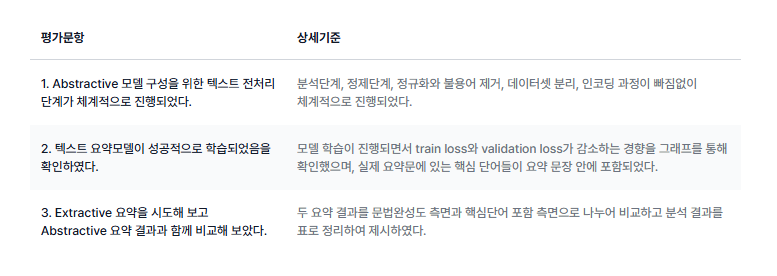